# Load and viz data

In [1]:
import util
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import core
import numpy as np
from importlib import reload
import pdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import random
from tensorflow.keras import backend as K
from scipy import stats

DPI = 120
IMG_PATH_PREFIX = 'writeup/images/'

def save_fig(fig, file_prefix):
  fig.tight_layout()
  fig.savefig(f"{IMG_PATH_PREFIX}{file_prefix}.png", format='png', dpi=DPI, bbox_inches='tight')

params = {
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
          }
pylab.rcParams.update(params)

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

data_path = "data/lorenz_rho_28_long.mat"

In [2]:
ts, ys = util.load_lorenz_data(data_path)
T = len(ts)

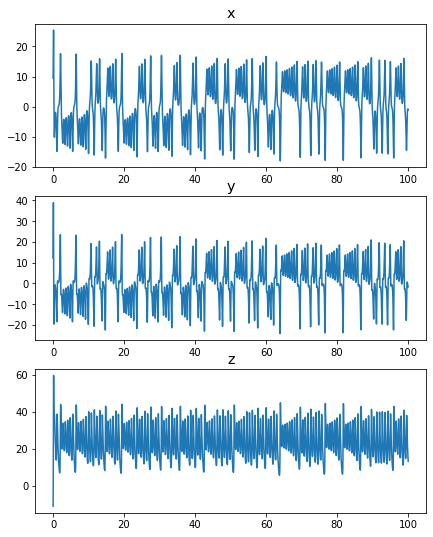

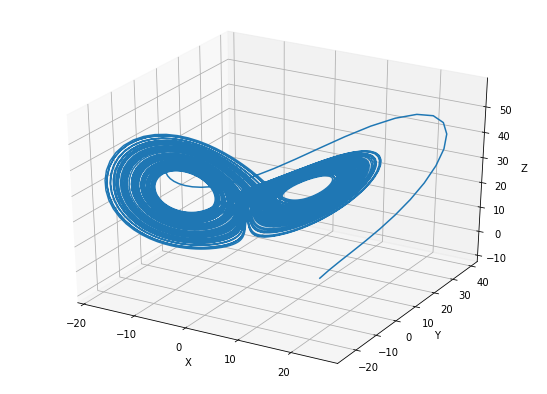

In [3]:
fig = util.plot_lorenz_2ds(ts, ys)
fig = util.plot_lorenz_3d(ts, ys)

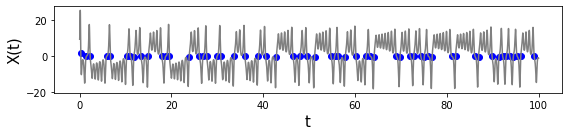

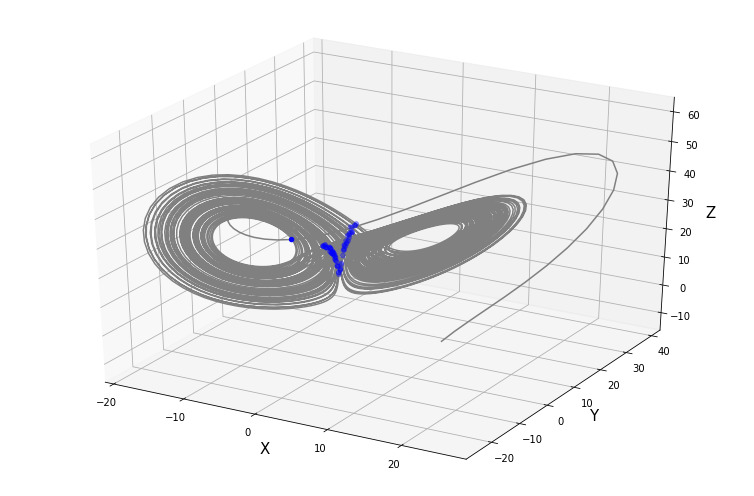

In [4]:
#%matplotlib
xt = ys[:,0]
yt = ys[:,1]
zt = ys[:,2]
thres_x = 0

# Get times when you cross the threshold.
is_above = xt > thres_x
t_trans = np.where(is_above[:-1] != is_above[1:])[0]

# Visualize the transition points
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(ts, xt, c='grey')
ax.scatter(ts[t_trans], xt[t_trans], c = 'blue')
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("X(t)", fontsize=15)
save_fig(fig, "lorenz_trans_2d_label")

# Same viz, but in 3D
fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)
ax.plot(xt, yt, zt, c='grey')
ax.scatter(xt[t_trans], yt[t_trans],
           zt[t_trans], c='blue')
save_fig(fig, "lorenz_trans_3d_label")


In [5]:
# Input = xt,yt,zt, output = distance to the next time = cur t - 
# Label(t) = Given that I am at xt,yt,zt, how many more dt's until I hit the next transition point?
# We remove the last segment, when we don't know the next transition point. 
labelt = []
# Points to the next transition index
next_trans_i = 0
for t in range(T):
  t_next = t_trans[next_trans_i]
  labelt.append(t_next - t)
  if t_next == t:
    next_trans_i += 1
    if next_trans_i >= len(t_trans):
      # Hit last segment where there is no more transition.
      break

# Truncate ys to exclude the trans-less last segment
ys = ys[:len(labelt),:]

# Split into train and test

In [6]:
# We remove a middle chunk of the original time series to reduce
# correlation between train and test.
TRAIN_T = 7000
TEST_T = 2000
train_ys = ys[:TRAIN_T, :]
train_labels = np.array(labelt[:TRAIN_T])
test_ys = ys[-TEST_T:,:]
test_labels = np.array(labelt[-TEST_T:])

In [7]:
stats.describe(train_labels)

DescribeResult(nobs=7000, minmax=(0, 486), mean=127.664, variance=10458.207419345621, skewness=0.9620704283515922, kurtosis=0.3281657253651895)

# Train

In [8]:
def build_model(N):
  model = tf.keras.Sequential()
  # 3 inputs for x,y,z
  model.add(Dense(N , activation='sigmoid', input_shape=(3,)))
  model.add(Dense(N , activation='sigmoid'))
  model.add(Dense(N , activation='sigmoid'))
  
  # Output = time for next transition
  model.add(layers.Dense(1))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss='mse',
                metrics=['mse'])
  return model

In [ ]:
# Uncomment if you want to retrain.
# best_N = 10
# best_model = build_model(best_N)
# history = best_model.fit(train_ys, train_labels, epochs=100, batch_size=32, shuffle=True)

In [9]:
# Save best model.
#best_model.save('best_model_trans')
best_model = tf.keras.models.load_model('best_model_trans')

In [10]:
train_preds = best_model.predict(train_ys)

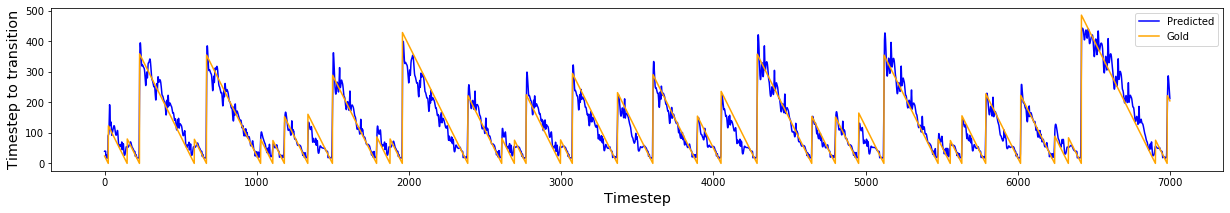

In [11]:
fig, ax = plt.subplots(figsize=(21,3))
timesteps = range(train_preds.shape[0])
ax.plot(timesteps, train_preds, label = "Predicted", c="blue")
ax.plot(timesteps, train_labels, label = "Gold", c="orange")
ax.set_xlabel("Timestep")
ax.set_ylabel("Timestep to transition")
ax.legend()

# Test results

In [27]:
test_preds = best_model.predict(test_ys)

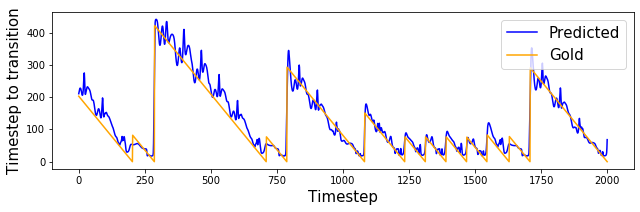

In [28]:
fig, ax = plt.subplots(figsize=(9,3))
timesteps = range(test_preds.shape[0])
ax.plot(timesteps, test_preds, label = "Predicted", c="blue")
ax.plot(timesteps, test_labels, label = "Gold", c="orange")
ax.set_xlabel("Timestep", fontsize=15)
ax.set_ylabel("Timestep to transition", fontsize=15)
ax.legend(fontsize=15)
save_fig(fig, "lorenz_trans_pred")

In [29]:
test_errors = np.abs(test_preds.T-test_labels)[0]

In [30]:
stats.describe(test_errors)

DescribeResult(nobs=2000, minmax=(0.0286102294921875, 261.8658142089844), mean=20.225870675086973, variance=395.93898344080816, skewness=2.783831122597396, kurtosis=18.241233309924034)

In [32]:
# Divide the actual jump labels into discrete buckets
bucket_walls = 10 * np.arange(1,15)
# For each bucket, the sum of the errors
bucket_sums = np.zeros(len(bucket_walls))
# For each bucket, the number of items in the bucket
bucket_counts = np.zeros(len(bucket_walls))

for i in range(len(test_errors)):
  err = test_errors[i]
  actual = test_labels[i]
  # first index of element greater than actual.
  bucket = np.argmax(bucket_walls > actual)
  bucket_sums[bucket] += err
  bucket_counts[bucket] += 1

avg_err_per_bucket = bucket_sums / bucket_counts  

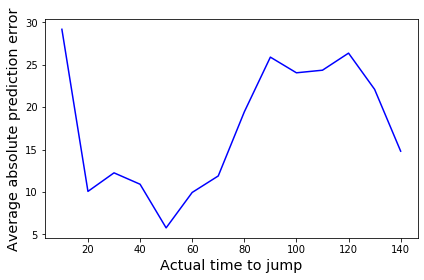

In [34]:
fig, ax = plt.subplots()
ax.plot(bucket_walls, avg_err_per_bucket, c="blue")
ax.set_xlabel("Actual time to jump")
ax.set_ylabel("Average absolute prediction error")
save_fig(fig,"lorenz_trans_error_per_trans_time")

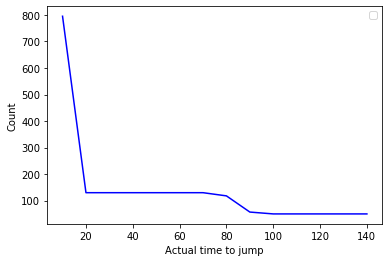

In [73]:
fig, ax = plt.subplots()
ax.plot(bucket_walls, bucket_counts, c="blue")
ax.set_xlabel("Actual time to jump")
ax.set_ylabel("Count")
ax.legend()